# Urban POMDP

In [1]:
using POMDPs, StatsBase, POMDPToolbox, RLInterface, Parameters, GridInterpolations
using AutomotiveDrivingModels,AutoViz
using Reel 

In [2]:
# include("AutomotivePOMDPs.jl")
using AutomotivePOMDPs
using AutomotiveSensors

In [3]:
rng = MersenneTwister(1);

In [4]:
params = UrbanParams(nlanes_main=1,
                     crosswalk_pos =[VecSE2(6, 0., pi/2), VecSE2(-6, 0., pi/2), VecSE2(0., -5., 0.)],
                     crosswalk_length =  [14.0, 14., 14.0],
                     crosswalk_width = [4.0, 4.0, 3.1],
                     stop_line = 22.0)
env = UrbanEnv(params=params);
obs_dist = ObstacleDistribution(env)
pomdp = UrbanPOMDP(env=env, 
                   sensor=PerfectSensor(),
                   obs_dist=obs_dist,
                   max_obstacles=1,
                   max_peds=1,
                   max_cars=5, 
                   ped_birth=0.1, 
                   ego_goal=LaneTag(2, 1));

In [5]:
policy = solve(RandomSolver(rng), pomdp)
up = updater(policy);
policy = FunctionPolicy(s->UrbanAction(0.0))

POMDPToolbox.FunctionPolicy(#3)

In [17]:
hr = HistoryRecorder(rng=rng, max_steps=20)
@time hist = simulate(hr, pomdp, policy, up);

  0.045259 seconds (186.84 k allocations: 5.614 MiB, 33.33% gc time)


In [18]:
duration, fps, render_hist = animate_scenes(hist.state_hist, pomdp.env, overlays = SceneOverlay[IDOverlay()], sim_dt=pomdp.ΔT, cam=StaticCamera(VecE2(0.,-10.), 14.))
speed_factor = 2.
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmph5qnMA", 0x0000000000000015, 4.0, nothing)

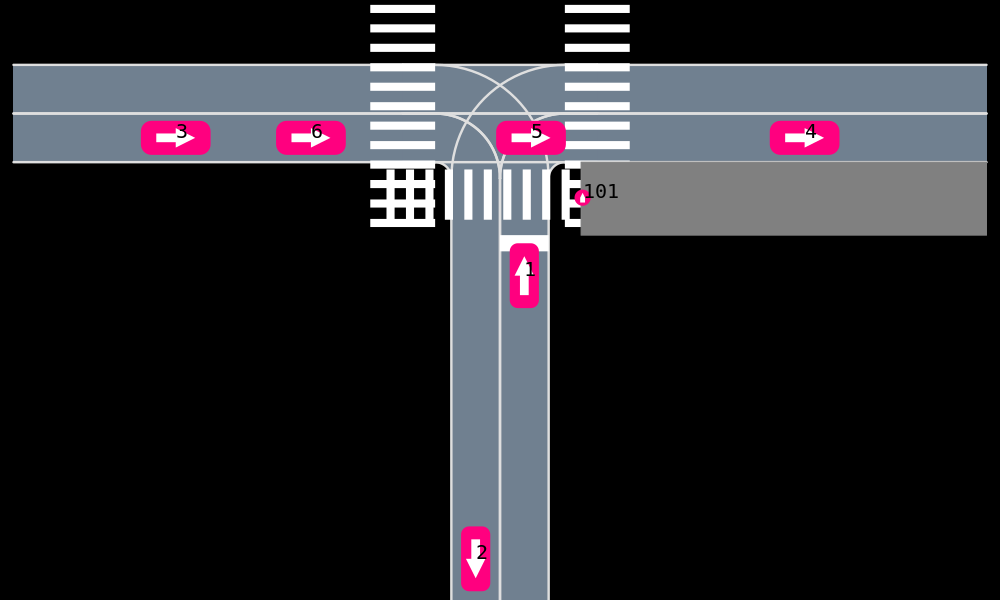

In [19]:
s = obs_to_scene(pomdp, hist.observation_hist[end])
AutoViz.render(s, env, [IDOverlay()], cam=FitToContentCamera(0.))

In [8]:
for veh in hist.state_hist[20]
    println(veh)
end

LoadError: [91mUndefVarError: hist not defined[39m

In [ ]:
# Fast evaluation
probs = 0.:0.1:1.0
crash_array = zeros(length(probs))
for (j,prob) in enumerate(probs)
    pomdp.ped_birth = prob
    n_eval = 1000
    crashes, time_outs, successes = 0, 0, 0
#     sim = RolloutSimulator(rng=rng, max_steps=100)
    for i=1:n_eval
        hr = HistoryRecorder(rng=rng, max_steps=100)
        hist = simulate(hr, pomdp, policy, up)
        r_tot = discounted_reward(hist)
        if r_tot < 0.
            crashes += 1
        elseif r_tot == 0.
            time_outs += 1
            return
        else 
            successes += 1
        end
    end
    crash_array[j] = crashes
    println("Crashes : ", crashes/10, " Successes ", successes/10, " Time outs ", time_outs/10)
end

In [ ]:
lane = rand(rng, get_lanes(pomdp.env.roadway))
route = random_route(rng, pomdp.env.roadway, lane)
for l in route
    println(l.tag)
end

In [ ]:
conflict_lanes = get_conflict_lanes(pomdp.env.crosswalks[3], pomdp.env.roadway)
for l in conflict_lanes
    println(l.tag)
end

In [ ]:
intersect(conflict_lanes, route)

In [ ]:
AutoViz.render(initialstate(pomdp, rng, true), env, [IDOverlay()], cam=FitToContentCamera(0.))

In [ ]:
n_steps = 100
scenes = Scene[]
pomdp.ped_birth = 0.5
s = initialstate(pomdp, rng)
push!(scenes, s)
for step=1:n_steps
    sp = generate_s(pomdp, s, UrbanAction(0.), rng)
    s = sp
    push!(scenes, s)
end

In [ ]:
duration, fps, render_hist = animate_scenes(scenes, pomdp.env, overlays = SceneOverlay[IDOverlay()], sim_dt=pomdp.ΔT)
speed_factor = 2.
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

In [ ]:
pomdp.models[7].intersection_driver

In [ ]:
function initial_pedestrian(pomdp::UrbanPOMDP, scene::Scene, rng::AbstractRNG, first_scene::Bool = false)
    env = pomdp.env
    crosswalk_pos = env.params.crosswalk_pos

    # position along the crosswalk
    t0 = rand(rng, Uniform(-env.params.crosswalk_width/2, env.params.crosswalk_width/2))
    s0 = rand(rng, [0., get_end(env.crosswalk)])
    ϕ0 = float(π)
    if s0 == 0.
        ϕ0 = 0.
    end
    if first_scene
        s0 = rand(rng, Uniform(0., get_end(env.crosswalk)))
    end

    #velocity
    v0 = rand(rng, Uniform(0., env.params.ped_max_speed))
    posF = Frenet(env.crosswalk, s0, t0, ϕ0)

    ped_initialstate = VehicleState(posF, env.roadway, v0);

    # new id, increment last id
    max_id = 0
    for veh in scene
        if veh.id > max_id
            max_id = veh.id
        end
    end
    id = max_id + 1
    if max_id == 0
        id = 2
    end


    return Vehicle(ped_initialstate, AutomotivePOMDPs.PEDESTRIAN_DEF, id)
end

In [ ]:
scene = Scene()
models = Dict{Int, DriverModel}()
for i=1:5
    ped = initial_pedestrian(pomdp, scene, rng, true)
    push!(scene, ped)
    models[ped.id] = ConstantPedestrian()
end
# car = initial_car(pomdp, scene, rng)
# collision point 7.0, 4.5
car = Vehicle(VehicleState(Frenet(env.roadway[LaneTag(3,1)], 0.), env.roadway, 6.), VehicleDef(), 1)
push!(scene, car);
AutoViz.render(scene, env, cam=FitToContentCamera(0.))

In [ ]:
timestep = 0.5

lane = get_lane(pomdp.env.roadway, car)
route = random_route(rng, pomdp.env.roadway, lane)
intersection_entrances = get_start_lanes(pomdp.env.roadway)
if !(route[1] ∈ intersection_entrances)
    intersection = Lane[]
    intersection_exits = Lane[]
else
    intersection_exits = get_exit_lanes(pomdp.env.roadway)
    intersection=Lane[route[1], route[2]]
end
navigator = RouteFollowingIDM(route=route)
intersection_driver = StopIntersectionDriver(navigator= navigator,
#                                                        intersection=intersection,
                                                       intersection_entrances = intersection_entrances,
                                                       intersection_exits = intersection_exits,
                                                       stop_delta=0.,
                                                       accel_tol=0.)
cw_conflict_lanes = get_conflict_lanes(pomdp.env.crosswalk, pomdp.env.roadway)
crosswalk_driver = CrosswalkDriver(navigator = navigator,
                                   crosswalk = pomdp.env.crosswalk,
                                   conflict_lanes = cw_conflict_lanes,
                                   intersection_entrances = intersection_entrances,
                                   yield=!isempty(intersect(cw_conflict_lanes, route)),
                                   debug=true)
models[car.id] = UrbanDriver(navigator=navigator,
                        intersection_driver=intersection_driver,
                       crosswalk_driver=crosswalk_driver,
                            debug=true           )

nticks = 50
rec = SceneRecord(nticks+1, timestep)
@time simulate!(rec, scene, pomdp.env.roadway, models, nticks)

In [ ]:
cam = FitToContentCamera(0.)
duration, fps, render_rec = animate_record(pomdp.env, rec, sim_dt=timestep, overlays = SceneOverlay[IDOverlay()])
film = roll(render_rec, fps = fps, duration = duration)

In [ ]:
scene = initialstate(pomdp, rng)
AutoViz.render(scene, env, [IDOverlay()], cam=FitToContentCamera(0.))

In [ ]:
function lane_to_segment(lane::Lane, roadway::Roadway)
    # only works for straight lanes
    lane_a = get_posG(Frenet(lane, 0.), roadway)
    lane_b = get_posG(Frenet(lane, get_end(lane)), roadway)
    return LineSegment(lane_a, lane_b)
end

function  get_conflict_lanes(crosswalk::Lane, roadway::Roadway)
    # find lane intersecting with crosswalk 
    cw_seg = lane_to_segment(crosswalk, roadway)    
    conflict_lanes = Lane[]
    lanes = get_lanes(roadway)
    for lane in lanes
        lane_seg = lane_to_segment(lane, roadway)
        if intersects(lane_seg, cw_seg) && !(lane ∈ conflict_lanes)
            push!(conflict_lanes, lane)
        end
    end
    return conflict_lanes
end

# return +1 if going toward, -1 if going away
function direction_from_center(ped::Vehicle, crosswalk::Lane)
    s_ped = ped.state.posF.s
    Δs = get_end(crosswalk)/2 - s_ped
    return sign(Δs*cos(ped.state.posF.ϕ))
end

function is_crossing(ped::Vehicle, crosswalk::Lane, conflict_lanes::Vector{Lane})
    # check if the pedestrian is in the conflict zone
    for lane in conflict_lanes
        ped_f = Frenet(ped.state.posG, lane, roadway)
        if abs(ped_f.t) < lane.width/2
            return true
        end
    end
    # at this point, the pedestrian is not on the road
    # check if she is going to cross or not
    if direction_from_center(ped, crosswalk) > 0.
        return true
    end
    return false
end

In [ ]:
# given crosswalk compute the "conflict zone"
crosswalk = env.crosswalk
conflict_lanes = get_conflict_lanes(crosswalk, env.roadway)

ped = scene[findfirst(scene, 5)]
is_crossing(ped, crosswalk, conflict_lanes)

In [ ]:
function get_stop_zone(crosswalk::Lane, roadway::Roadway)
end

In [ ]:
length(conflict_lanes)

In [ ]:
lane_seg = lane_to_segment(lanes[3], roadway)

In [ ]:
methods(get_posG)

In [ ]:
roadway = env.roadway
veh = scene[findfirst(scene, 8)]
lane = get_lane(roadway, veh)

In [ ]:
methods(Frenet)

In [ ]:
function is_in_lane(veh::Vehicle, lane::Lane, roadway::Roadway)
    pos_g = veh.state.posG
    proj(pos_g, lane)
end

In [ ]:
methods(proj)

In [ ]:
using Interact

scene = Scene()

type LaneOverlay <: SceneOverlay
    lane::Lane
    color::Colorant
end
function AutoViz.render!(rendermodel::RenderModel, overlay::LaneOverlay, scene::Scene, roadway::Roadway)
    render!(rendermodel, overlay.lane, roadway, color_asphalt=overlay.color)
    return rendermodel
end

# @manipulate for i in 1 : length(env.roadway.segments)
#     AutoViz.render(scene, env.roadway, [LaneOverlay(env.roadway[LaneTag(i,1)], RGBA(0.0,0.0,1.0,0.5))], cam=FitToContentCamera(0.))
# end

i=8
AutoViz.render(scene, env.roadway, [LaneOverlay(env.roadway[LaneTag(i,1)], RGBA(0.0,0.0,1.0,0.5))], cam=FitToContentCamera(0.))

In [ ]:
env.roadway[LaneTag(1,1)].exits

In [ ]:
function is_straight(lane::Lane)
end